In [1]:
# importing necessary libraries which we will use
import pandas as pd
import matplotlib.pyplot as plt
from googletrans import Translator, constants
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import uvicorn
from fastapi import FastAPI
import pickle
RANDOM_STATE = 55 ## You will pass it to every sklearn call so we ensure reproducibility

In [70]:
# creating DataFrame for Excel file using pandas
df = pd.read_csv('tabela_producao_oleo.csv',low_memory= False)

In [71]:
# looking number of nulls for every column
df.isnull().sum()*100/len(df)

Estado                             0.000000
Bacia                              0.000000
NP_ANP                             0.000000
NP_Operador                        0.000000
Campo                              0.000000
Operador                           0.000000
Número do Contrato                 0.000000
Período                            0.000000
Óleo (bbl/dia)                     0.000000
Condensado (bbl/dia)               0.000000
Petróleo (bbl/dia)                 0.000000
GN_Associado                       0.000000
GN_Não associado                   0.000000
GN_Gás Total                       0.000000
Volume Gás                         0.000000
Água (bbl/dia)                     0.000000
Instalação Destino                62.201497
Tipo Instalação                   62.201497
Tempo de Produção (hs por mês)     0.000000
dtype: float64

In [4]:
# deleting these two columns ,because they have more than 30% nulls
del df['Instalação Destino']
del df['Tipo Instalação']

In [5]:
# using requests library,translating column names to English
import requests

column_tra = []

for i in range(len(df.columns)):

    src_text = df.columns[i]

    r = requests.get('https://translate.googleapis.com/translate_a/single?client=gtx&sl=pt&tl=en&dt=t&q=' + src_text)

    translated_text = r.json()[0][0][0]

    column_tra.extend(translated_text)
    print(df.columns[i],': ', translated_text)
    

Estado :  state
Bacia :  Bowl
NP_ANP :  NP_ANP
NP_Operador :  NP_Operator
Campo :  Field
Operador :  Operator
Número do Contrato :  Contact number
Período :  Period
Óleo (bbl/dia) :  Oil (bbl/day)
Condensado (bbl/dia) :  Condensate (bbl/day)
Petróleo (bbl/dia) :  Oil (bbl/day)
GN_Associado :  NG_Associate
GN_Não associado :  GN_Not associated
GN_Gás Total :  NG_Total Gas
Volume Gás :  Gas Volume
Água (bbl/dia) :  Water (bbl/day)
Tempo de Produção (hs por mês) :  Production time (hrs per month)


In [6]:
# renaming column names
df.rename(columns = {'Estado' :  'state','Bacia' :  'Bowl','NP_ANP' :  'NP_ANP','NP_Operador' :  'NP_Operator','Campo' :  'Field','Operador':  'Operator','Número do Contrato' :  'Contact number','Período' :  'Period','Óleo (bbl/dia)' :  'Oil (bbl/day)','Condensado (bbl/dia)' :  'Condensate (bbl/day)','Petróleo (bbl/dia)' :  'Petrol (bbl/day)','GN_Associado' :  'NG_Associate','GN_Não associado' :  'GN_Not associated','GN_Gás Total' :  'NG_Total Gas','Volume Gás' :  'Gas Volume','Água (bbl/dia)' :  'Water (bbl/day)','Tempo de Produção (hs por mês)' :  'Production time (hrs per month)'},inplace = True )

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Oil (bbl/day),2109401.0,283.339324,1962.978513,0.0000,0.65040,6.66410,20.70300,56094.15040
Condensate (bbl/day),2109401.0,0.998269,27.778907,0.0000,0.00000,0.00000,0.00000,7160.45410
Petrol (bbl/day),2109401.0,284.337593,1963.032205,0.0000,0.81330,6.83620,21.08910,56094.15040
NG_Associate,2109401.0,8.867402,76.012352,0.0000,0.00030,0.00560,0.09180,3230.28550
GN_Not associated,2109401.0,1.895056,35.322858,0.0000,0.00000,0.00000,0.00000,2087.20730
NG_Total Gas,2109401.0,10.762458,83.619776,0.0000,0.00050,0.00690,0.11990,3230.28550
Gas Volume,2109401.0,219.601967,1661.519688,0.0000,0.01029,0.17084,3.12444,64703.42696
Water (bbl/day),2109401.0,305.972579,1096.857121,-0.0056,0.78120,57.36920,248.76200,56772.52460
Production time (hrs per month),2109401.0,206.542901,316.095624,0.0000,0.00000,0.00000,640.00000,990.00000


In [8]:
# special cleaning function for making column names lowercase and ignoring any problems
def mycleaningfunction(df):
    df.columns = list(map(lambda x : x.strip().lower(),df.columns))
    for i in df.columns:
        if df[i].isnull().sum()/len(df)>0.3:
            df.drop(columns=[i],axis=1,inplace=True)
        if not i.isalnum():
            for j in i:
                if not j.isalnum():
                    i=i.replace(j,'')        
    return df

In [9]:
mycleaningfunction(df)
# ---------

,state,bowl,np_anp,np_operator,field,operator,contact number,period,oil (bbl/day),condensate (bbl/day),petrol (bbl/day),ng_associate,gn_not associated,ng_total gas,gas volume,water (bbl/day),production time (hrs per month)
0,Sergipe,Sergipe,7-GA-7D-SES,7GA 0007D SES,GUARICEMA,Petrobras,480000038399796,2005/01,76.5937,0.0,76.5937,0.0000,0.0,0.0000,0.00000,7.0405,31.0
1,Sergipe,Sergipe,7-GA-66D-SES,7GA66DSES,GUARICEMA,Petrobras,480000038399796,2005/01,71.3589,0.0,71.3589,0.0000,0.0,0.0000,0.00000,143.9758,31.0
2,Sergipe,Sergipe,7-GA-35D-SES,7GA 0035D SES,GUARICEMA,Petrobras,480000038399796,2005/01,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.00000,0.0000,31.0
3,Sergipe,Sergipe,7-GA-30-SES,7GA 0030 SES,GUARICEMA,Petrobras,480000038399796,2005/01,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.00000,0.0000,31.0
4,Sergipe,Sergipe,7-GA-58D-SES,7GA 0058D SES,GUARICEMA,Petrobras,480000038399796,2005/01,423.0607,0.0,423.0607,0.0000,0.0,0.0000,0.00000,1.8667,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109396,Bahia,Recôncavo,7-BA-73-BA,7BA 0073 BA,BURACICA,Petrobras,480000036359746,2022/03,9.2101,0.0,9.2101,0.0094,0.0,0.0094,0.29038,739.4759,698.0
2109397,Bahia,Recôncavo,7-BA-75-BA,7BA 0075 BA,BURACICA,Petrobras,480000036359746,2022/03,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.00000,0.0000,0.0
2109398,Bahia,Recôncavo,7-BA-81-BA,7BA 0081 BA,BURACICA,Petrobras,480000036359746,2022/03,0.5503,0.0,0.5503,0.0042,0.0,0.0042,0.13072,143.1695,41.0
2109399,Bahia,Recôncavo,7-BA-92-BA,7BA 0092 BA,BURACICA,Petrobras,480000036359746,2022/03,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.00000,0.0000,0.0


In [10]:
df.columns

Index(['state', 'bowl', 'np_anp', 'np_operator', 'field', 'operator',
       'contact number', 'period', 'oil (bbl/day)', 'condensate (bbl/day)',
       'petrol (bbl/day)', 'ng_associate', 'gn_not associated', 'ng_total gas',
       'gas volume', 'water (bbl/day)', 'production time (hrs per month)'],
      dtype='object')

In [11]:
print(df.duplicated().sum())
# df.drop_duplicates(inplace= True)

14872


In [18]:
data = df[['period','petrol (bbl/day)']];

In [20]:
data = data.groupby(by='period').sum()
data.reset_index('period')
data.rename(columns= {'petrol (bbl/day)':'values'},inplace= True)

In [14]:
data1 = pd.DataFrame(pd.date_range(data.index.min(),data.index.max()))
# data1.apply(lambda value :value.replace())
data1[0] = data1[0].apply(lambda value : str(value)[0:7])
data1.drop_duplicates(inplace= True)
if len(data) - len(data1) == 0:
    print('time got sequencely')

time got sequencely


<AxesSubplot:xlabel='period'>

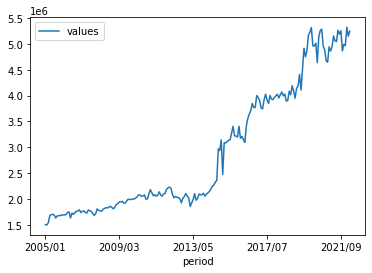

In [21]:
data.plot()

In [16]:
def linreg(X, Y):
    N = len(X)
    Sx = Sy = Sxx = Syy = Sxy = 0.0
    for x, y in zip(X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    return (Sxy * N - Sy * Sx)/det, (Sxx * Sy - Sx * Sxy)/det
m, n = linreg(range(len(data)), data['values'])
print(f'slope: {m} \nintercept: {n}')

slope: 19072.01588590744 
intercept: 933079.9612819689


In [22]:
# based on just values creating auto-arima statisical model
from pmdarima.arima import auto_arima

# Step 6: Choose a model
model = auto_arima(data, m=12, suppress_warnings=True)

# Step 7: Train the model
model_fit = model.fit(data)




In [24]:
# predicting next 1 year's petrol levels
month_pred = 12
future_predictions = model_fit.predict(n_periods = month_pred)
future_predictions

2022-04-01    5.254137e+06
2022-05-01    5.276485e+06
2022-06-01    5.295611e+06
2022-07-01    5.315340e+06
2022-08-01    5.334957e+06
2022-09-01    5.354595e+06
2022-10-01    5.374228e+06
2022-11-01    5.393863e+06
2022-12-01    5.413497e+06
2023-01-01    5.433132e+06
2023-02-01    5.452766e+06
2023-03-01    5.472401e+06
Freq: MS, dtype: float64

In [ ]:
# for this project,this can be seemed as optional
# using Fastapi  and pickle getting result for upcoming observation

filename = 'regres_ts_model.sav'
pickle.dump(regr, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X,y)

def dataset(pclass):
    observation = {"pred_month": [month_pred]}

    dataframe = pd.DataFrame(data = observation)
    
    return dataframe

app = FastAPI()

pickle_model = open("regres_ts_model.sav", "rb")
model = pickle.load(pickle_model)

@app.post('/Predict Brasil Oil in next months')
def predict_oil_volume(month_pred: int,):
    """   Brasil monthly oil prediction. 
    Date - monthly date
    y -monthly oil  
"""
    user_data = dataset(month_pred)
    
    
    prediction = model.predict(X)
    
    return { str(df.tail(month_pred)[['Date','y']])}

import nest_asyncio
nest_asyncio.apply()

if __name__ == '__main__':
    uvicorn.run(app, host = '127.0.0.1', port = 5000)

# at the end click this link: http://127.0.0.1:5000/docs

In [25]:
# moving averages
data['ma3'] = data['values'].rolling(3, closed = 'left').mean()
data['ma5'] = data['values'].rolling(5, closed = 'left').mean()

In [26]:
# determining sequence,trend and making detrend
data['sequence'] = [*range(1,len(data)+1)]
data['trend'] = data['sequence'] * m + n
data['detrend'] =  data['values'] - data['trend']

In [27]:
# creating lags, lokking for specified previous days' values
data['Lag1'] = data['values'].shift(1)
data['Lag6'] = data['values'].shift(6)
data['Lag5'] = data['values'].shift(5)
data['Lag12'] = data['values'].shift(12)

<AxesSubplot:xlabel='period'>

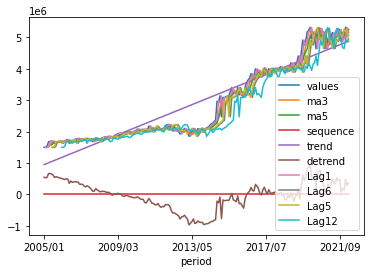

In [28]:
data.plot()

In [29]:
data.dropna(inplace = True)

In [30]:
data.corr()

,values,ma3,ma5,sequence,trend,detrend,Lag1,Lag6,Lag5,Lag12
values,1.000000,0.992636,0.991577,0.938980,0.938980,0.489846,0.993112,0.979925,0.982761,0.964467
ma3,0.992636,1.000000,0.998880,0.938472,0.938472,0.470004,0.997028,0.987355,0.989793,0.970879
ma5,0.991577,0.998880,1.000000,0.938223,0.938223,0.467595,0.994971,0.991342,0.994846,0.974994
sequence,0.938980,0.938472,0.938223,1.000000,1.000000,0.160079,0.937476,0.929812,0.931455,0.920789
trend,0.938980,0.938472,0.938223,1.000000,1.000000,0.160079,0.937476,0.929812,0.931455,0.920789
detrend,0.489846,0.470004,0.467595,0.160079,0.160079,1.000000,0.473891,0.455473,0.459449,0.433982
Lag1,0.993112,0.997028,0.994971,0.937476,0.937476,0.473891,1.000000,0.982666,0.985085,0.965656
Lag6,0.979925,0.987355,0.991342,0.929812,0.929812,0.455473,0.982666,1.000000,0.992998,0.979113
Lag5,0.982761,0.989793,0.994846,0.931455,0.931455,0.459449,0.985085,0.992998,1.000000,0.976616
Lag12,0.964467,0.970879,0.974994,0.920789,0.920789,0.433982,0.965656,0.979113,0.976616,1.000000


In [31]:
del data['trend']

In [32]:
train = data[:150]
test = data[150:]

y_train = train['values']
X_train = train.drop( columns = ['values'] )

y_test = test['values']
X_test = test.drop( columns = ['values'] )

In [35]:
# creating Linear Regression model
reg = LinearRegression().fit(X_train, y_train)

In [36]:
reg.score(X_test, y_test)

1.0

In [37]:
reg.coef_

array([ 1.00540860e-11, -3.15664161e-12,  1.90720159e+04,  1.00000000e+00,
       -8.80581719e-12,  1.40304435e-13, -2.28145280e-12, -6.73072709e-14])

In [38]:
reg.intercept_

933079.9612865911

In [39]:
# deleting duplicates
df = df.drop_duplicates()

In [40]:
# our target column is petrol,let's rename it
df.rename(columns = {'petrol (bbl/day)' : 'target'},inplace = True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
df.dtypes

state                               object
bowl                                object
np_anp                              object
np_operator                         object
field                               object
operator                            object
contact number                      object
period                              object
oil (bbl/day)                      float64
condensate (bbl/day)               float64
target                             float64
ng_associate                       float64
gn_not associated                  float64
ng_total gas                       float64
gas volume                         float64
water (bbl/day)                    float64
production time (hrs per month)    float64
dtype: object

In [42]:
# getting numeric columns
numerics = []
for i in df.columns:
    if df[i].dtype == 'float64':
        numerics.append(i)
numerics        

['oil (bbl/day)',
 'condensate (bbl/day)',
 'target',
 'ng_associate',
 'gn_not associated',
 'ng_total gas',
 'gas volume',
 'water (bbl/day)',
 'production time (hrs per month)']

In [43]:
# our target column is petrol,looking its correlation with others
for i in numerics:
    print(i,df[i].corr(df['target']))

oil (bbl/day) 0.9998448727401478
condensate (bbl/day) 0.012615555282149804
target 1.0
ng_associate 0.8193069050965208
gn_not associated 0.004437500157468834
ng_total gas 0.7044750205437226
gas volume 0.5573056524232849
water (bbl/day) 0.27116475947186996
production time (hrs per month) 0.053369157094019605


In [44]:
# we can delete gn_not associated column,because it has very low correlation
del df['gn_not associated']

In [45]:
# getting categoric columns
categorics = []
for i in df.columns:
    if df[i].dtype == 'object':
        categorics.append(i)
categorics        

['state',
 'bowl',
 'np_anp',
 'np_operator',
 'field',
 'operator',
 'contact number',
 'period']

In [46]:
for i in categorics:
    print(i , len(df[i].value_counts()))

state 11
bowl 14
np_anp 43828
np_operator 30947
field 495
operator 83
contact number 513
period 207


In [47]:
# one hot encode state column
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['state']]).toarray())

enc_df.columns = enc.get_feature_names_out()

df = df.join(enc_df)
df.drop('state',axis=1,inplace=True)

In [48]:
# one hot encode bowl column
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['bowl']]).toarray())

enc_df.columns = enc.get_feature_names_out()

df = df.join(enc_df)
df.drop('bowl',axis=1,inplace=True)

In [49]:
# splitting period into year and month
df[['year', 'month']] = df['period'].str.split('/', expand=True)

# convert the data type of the new columns to integer
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)


In [50]:
del df['period']

In [51]:
df.isnull().sum()

np_anp                                 0
np_operator                            0
field                                  0
operator                               0
contact number                         0
oil (bbl/day)                          0
condensate (bbl/day)                   0
target                                 0
ng_associate                           0
ng_total gas                           0
gas volume                             0
water (bbl/day)                        0
production time (hrs per month)        0
state_Alagoas                      14514
state_Amazonas                     14514
state_Bahia                        14514
state_Ceará                        14514
state_Espírito Santo               14514
state_Maranhão                     14514
state_Paraná                       14514
state_Rio Grande do Norte          14514
state_Rio de Janeiro               14514
state_Sergipe                      14514
state_São Paulo                    14514
bowl_Alagoas    

In [52]:
df.dropna(inplace = True)

In [53]:
# for converting other categoric columns into numerics
# splitting field column into two with using its values standard deviation according to target column
stds = pd.DataFrame(df.groupby(by='field').agg({'target':['std']}))
stds.columns = ['std_' + '_'.join(col).strip() for col in stds.columns.values]
stds = stds.reset_index().rename(columns={'field': 'field', 'std_target_std': 'std'})
stds

,field,std
0,ABALONE,429.962608
1,ACAJÁ-BURIZINHO,2.879224
2,ACAUÃ,3.796956
3,AGUILHADA,62.056847
4,AGULHA,72.649874
...,...,...
489,VIOLA,437.266050
490,VOADOR,1464.539385
491,VÁRZEA REDONDA,14.370918
492,XARÉU,75.776546


In [54]:
stds.describe()

,std
count,486.000000
mean,612.691944
std,2001.758058
min,0.000000
25%,6.788423
50%,19.147297
75%,83.987849
max,17192.098900


In [55]:
fieldlowstd = []
fieldhighstd = []
for index, row in stds.iterrows():
    if row['std'] < 20:
        fieldlowstd.append(row['field'])
    else:
        fieldhighstd.append(row['field'])

In [56]:
df['fieldlowstd'] = df['field'].isin(fieldlowstd)
df['fieldhighstd'] = df['field'].isin(fieldhighstd)

In [57]:
# doing same for operator column with mean
means = pd.DataFrame(df.groupby(by='operator').agg({'target':['mean']}))
means.columns = ['mean_' + '_'.join(col).strip() for col in means.columns.values]
means = means.reset_index().rename(columns={'operator': 'operator', 'mean_target_mean': 'mean'})
means

,operator,mean
0,-,4.856364
1,3R Areia,9.568962
2,3R MACAU S.A.,25.016538
3,3R Macau,31.130466
4,3R PETROLEUM,12.673800
...,...,...
76,Trident Energy,200.415947
77,UP Petróleo,70.366791
78,UTC Engenharia,0.035178
79,Ubuntu Engenharia,2.470660


In [58]:
means.describe()

,mean
count,81.000000
mean,628.731039
std,1699.336505
min,0.000000
25%,3.446546
50%,12.149298
75%,70.366791
max,9078.933800


In [59]:
operatorlowmean = []
operatorhighmean = []
for index, row in means.iterrows():
    if row['mean'] < 20:
        operatorlowmean.append(row['operator'])
    else:
        operatorhighmean.append(row['operator'])

In [60]:
df['operatorlowmean'] = df['operator'].isin(operatorlowmean)
df['operatorhighmean'] = df['operator'].isin(operatorhighmean)

In [61]:
del df['field']
del df['operator']

In [62]:
# deleting np_anp and np_operator, due to containing redundant information and having very high cardinality 
del df['np_anp']
del df['np_operator']

In [63]:
# looking sums of target based on contact number
sums = pd.DataFrame(df.groupby(by='contact number').agg({'target':['sum']}))
sums.columns = ['sum_' + '_'.join(col).strip() for col in sums.columns.values]
sums = sums.reset_index().rename(columns={'contact number': 'contact number', 'sum_target_sum': 'sum'})
sums.describe()

,sum
count,5.120000e+02
mean,9.057493e+05
std,5.115566e+06
min,0.000000e+00
25%,1.378319e+02
50%,4.193442e+03
75%,9.161763e+04
max,7.063753e+07


In [64]:
numberlowsum = []
numberhighsum = []
for index, row in sums.iterrows():
    if row['sum'] < 4000:
        numberlowsum.append(row['contact number'])
    else:
        numberhighsum.append(row['contact number'])

In [65]:
df['numberlowsum'] = df['contact number'].isin(numberlowsum)
df['numberhighsum'] = df['contact number'].isin(numberhighsum)

In [66]:
df.replace({False:0, True:1}, inplace=True)

In [67]:
# just look at sum of target , and decide importance of numbers(customers) 
del df['contact number']

In [68]:
df

,oil (bbl/day),condensate (bbl/day),target,ng_associate,ng_total gas,gas volume,water (bbl/day),production time (hrs per month),state_Alagoas,state_Amazonas,...,bowl_Solimões,bowl_Tucano Sul,year,month,fieldlowstd,fieldhighstd,operatorlowmean,operatorhighmean,numberlowsum,numberhighsum
0,76.5937,0.0,76.5937,0.0000,0.0000,0.00000,7.0405,31.0,0.0,0.0,...,0.0,0.0,2005,1,0,1,0,1,0,1
1,71.3589,0.0,71.3589,0.0000,0.0000,0.00000,143.9758,31.0,0.0,0.0,...,0.0,0.0,2005,1,0,1,0,1,0,1
2,0.0000,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,31.0,0.0,0.0,...,0.0,0.0,2005,1,0,1,0,1,0,1
3,0.0000,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,31.0,0.0,0.0,...,0.0,0.0,2005,1,0,1,0,1,0,1
4,423.0607,0.0,423.0607,0.0000,0.0000,0.00000,1.8667,31.0,0.0,0.0,...,0.0,0.0,2005,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094524,4.6659,0.0,4.6659,0.0059,0.0059,0.16607,60.8896,667.0,0.0,0.0,...,0.0,0.0,2022,2,1,0,0,1,0,1
2094525,5.7208,0.0,5.7208,0.0073,0.0073,0.20364,20.4531,667.0,0.0,0.0,...,0.0,0.0,2022,2,1,0,0,1,0,1
2094526,2.7668,0.0,2.7668,0.0035,0.0035,0.09846,23.8121,665.0,0.0,0.0,...,0.0,0.0,2022,2,1,0,0,1,0,1
2094527,2.5582,0.0,2.5582,0.0033,0.0033,0.09104,32.0039,671.0,0.0,0.0,...,0.0,0.0,2022,2,1,0,0,1,0,1


In [69]:
df.dtypes

oil (bbl/day)                      float64
condensate (bbl/day)               float64
target                             float64
ng_associate                       float64
ng_total gas                       float64
gas volume                         float64
water (bbl/day)                    float64
production time (hrs per month)    float64
state_Alagoas                      float64
state_Amazonas                     float64
state_Bahia                        float64
state_Ceará                        float64
state_Espírito Santo               float64
state_Maranhão                     float64
state_Paraná                       float64
state_Rio Grande do Norte          float64
state_Rio de Janeiro               float64
state_Sergipe                      float64
state_São Paulo                    float64
bowl_Alagoas                       float64
bowl_Amazonas                      float64
bowl_Barreirinhas                  float64
bowl_Camamu                        float64
bowl_Campos

In [ ]:
# optional normalization, we can also do that for better modelling
df = (df - df.mean()) / df.std()
# this makes z-score normalization and controls mean and deviation of data

In [45]:
# this is implemented for Random forest model,because otherwise it makes overffiting over oil column
X = df.drop(columns = {'target','oil (bbl/day)'})
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [46]:
# building Random forest model
random_forest_model = RandomForestRegressor(max_depth = 5, min_samples_split = 10).fit(X_train,y_train)

In [47]:
# getting score.it is pretty good
random_forest_model.score(X_test,y_test)

0.8480563701762049

In [ ]:
# this is applied for Neural netwrok ,because we will add regularization to it
X = df.drop(columns = {'target'})
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [113]:
# using tensorflow library,creating Neural network with 2 hidden layers having 25 and 15 units respectively,and with kernel regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(25, activation='relu', input_shape=[X_train.shape[1]],
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])

In [115]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
48751/48751 [==============================] - 108s 2ms/step - loss: 366.4801
Epoch 2/10
48751/48751 [==============================] - 104s 2ms/step - loss: 297.6612
Epoch 3/10
48751/48751 [==============================] - 136s 3ms/step - loss: 226.5736
Epoch 4/10
48751/48751 [==============================] - 159s 3ms/step - loss: 225.3783
Epoch 5/10
48751/48751 [==============================] - 156s 3ms/step - loss: 237.7254
Epoch 6/10
48751/48751 [==============================] - 128s 3ms/step - loss: 189.3698
Epoch 7/10
48751/48751 [==============================] - 109s 2ms/step - loss: 167.8598
Epoch 8/10
48751/48751 [==============================] - 105s 2ms/step - loss: 177.5710
Epoch 9/10
48751/48751 [==============================] - 95s 2ms/step - loss: 139.9903
Epoch 10/10
48751/48751 [==============================] - 95s 2ms/step - loss: 131.0393


In [118]:
# evaluate the model on test data
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

16251/16251 [==============================] - 23s 1ms/step


In [119]:
# becuase we built complex model(and have a lot of features), we get very low mean squared error
mse

1.0335055118163707